In [28]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

### Get a sample stock price from 2019-01-01 to today

In [2]:
# Get the data of the Apple stock (code AAPL)
data = yf.download('AAPL','2019-01-01','2020-04-30')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,158.529999,159.360001,156.479996,157.740005,154.618546,35003500
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.794983,37039700
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.376251,91312200
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.326126,58607100
2019-01-07,148.699997,148.830002,145.899994,147.929993,145.002686,54777800


### Extract the Close price column to plot

In [3]:
df = pd.DataFrame(data, columns=['Close'])
df = df.reset_index()
df.isna().values.any() # check for NaN

False

In [4]:
print(type(df['Date'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


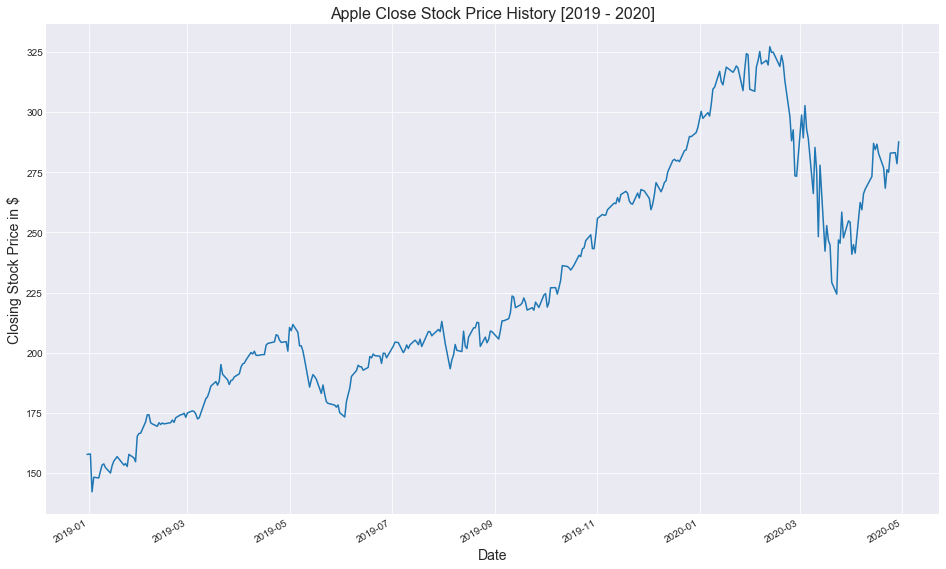

In [5]:
# Import matplotlib package for date plots

months = mdates.AutoDateLocator()
dateFmt = mdates.AutoDateFormatter(months) # Set year format

# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'])

# Format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)

# Set figure title
plt.title('Apple Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

In [6]:
print(ax)

AxesSubplot(0.125,0.2;0.775x0.68)


### Get stock of Apple, Google, Microsoft, Amazon, Facebook via Yahoo Finance

In [7]:
def get_close_stock_price(codes, start_date='2019-01-01', end_date='2020-04-30'):
    data = { code : yf.download(code, start_date, end_date) for code in codes }
    data = { key : pd.DataFrame(value, columns=['Close']).rename(columns={'Close': f'{key}'}) for key, value in data.items() }
    df = None
    for key, value in data.items():
        if df is None:
            df = value
        else:
            df = df.merge(value, left_index=True, right_index=True)
    return df

df = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'])
df.to_csv('data/close_price_big_5.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
df = pd.read_csv('data/close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
df.head()

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2018-12-31,157.740005,1044.959961,101.570000,1501.969971,131.089996
2019-01-02,157.919998,1054.680054,101.120003,1539.130005,135.679993
2019-01-03,142.190002,1025.469971,97.400002,1500.280029,131.740005
2019-01-04,148.259995,1078.069946,101.930000,1575.390015,137.949997
2019-01-07,147.929993,1075.920044,102.059998,1629.510010,138.050003


In [9]:
df.index

DatetimeIndex(['2018-12-31', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-14',
               ...
               '2020-04-16', '2020-04-17', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-27',
               '2020-04-28', '2020-04-29'],
              dtype='datetime64[ns]', name='Date', length=335, freq=None)

In [10]:
df_plot = df.reset_index().melt('Date', var_name='cols',  value_name='vals')
df_plot.isna().values.any()

False

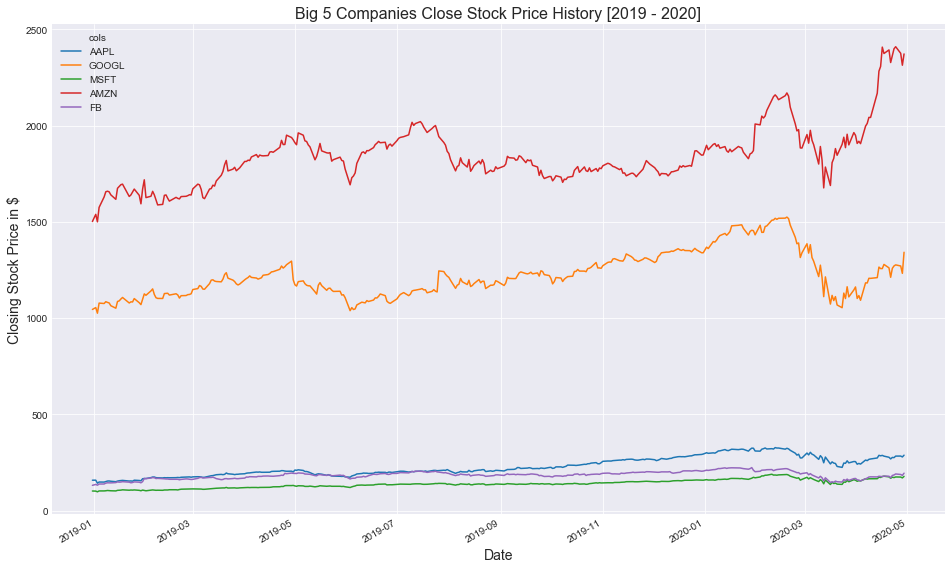

In [11]:
# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Big 5 Companies Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

### Create X, y matrices for regression
Use history = number of days before prediction date

In [43]:
def create_Xy(df, history=1):
    '''df has index as date
    columns are stock price of the companies
    '''
    X, y, dates = [], [], []
    for row_idx in range(history, len(df)):
        y.append( df.iloc[row_idx,:].values.reshape(-1) )
        tmp = df.iloc[row_idx-history:row_idx,:].values.reshape(-1)
        tmp = np.hstack((tmp,tmp.mean()))
        X.append(tmp)
        dates.append(df.index[row_idx])
    X, y = np.array(X), np.array(y)
    return X, y, dates


X,y,dates = create_Xy(df['AAPL'], history=5)

scaler_x = StandardScaler()
scaler_x = scaler_x.fit(X)
X = scaler_x.transform(X)

scaler_y = StandardScaler()
scaler_y = scaler_y.fit(y)
y = scaler_y.transform(y)
print(X)
print(y)
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

IndexingError: Too many indexers

### Create a Linear Regression Model to predict stock price

In [40]:
clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_tr)

NameError: name 'X_tr' is not defined

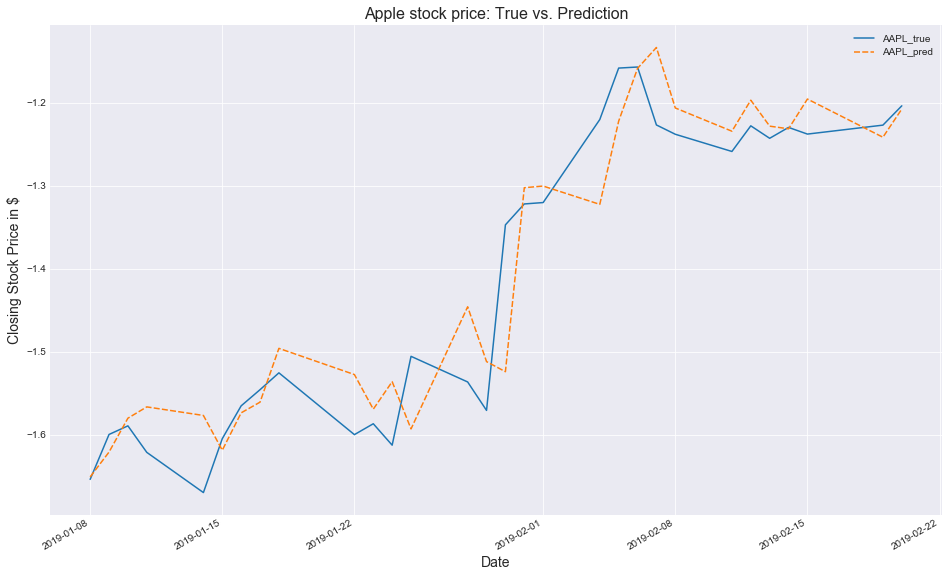

In [41]:
df_plot = pd.DataFrame({"AAPL_true": y_train[:30,0], 'AAPL_pred': ypred[:30,0]}, index=dates_train[:30])

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Apple stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

# Exercise
1. Play with the above code to get familiar with stock price data and ways to create training data ( X = past stock price, y = future stock price )
2. Investigate if stock price of Big 5 companies are related to each other ( “FAAMG”—Facebook, Amazon, Apple, Microsoft, and Google )
3. Determine the features that could predict future stock price ( stock price from Yahoo Finance could be considered as raw features, create new features if needed )
4. Build a linear regression model to predict future stock price
5. Evaluate your model performance

In [42]:
df

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2018-12-31,157.740005,1044.959961,101.570000,1501.969971,131.089996
2019-01-02,157.919998,1054.680054,101.120003,1539.130005,135.679993
2019-01-03,142.190002,1025.469971,97.400002,1500.280029,131.740005
2019-01-04,148.259995,1078.069946,101.930000,1575.390015,137.949997
2019-01-07,147.929993,1075.920044,102.059998,1629.510010,138.050003
...,...,...,...,...,...
2020-04-23,275.029999,1271.170044,171.419998,2399.449951,185.130005
2020-04-24,282.970001,1276.599976,174.550003,2410.219971,190.070007
2020-04-27,283.170013,1270.859985,174.050003,2376.000000,187.500000


In [24]:
df['AAPL']

Date
2018-12-31    157.740005
2019-01-02    157.919998
2019-01-03    142.190002
2019-01-04    148.259995
2019-01-07    147.929993
                 ...    
2020-04-23    275.029999
2020-04-24    282.970001
2020-04-27    283.170013
2020-04-28    278.579987
2020-04-29    287.730011
Name: AAPL, Length: 335, dtype: float64